In [1]:
from common import *
disable_fig_save = False 
save_loc = 'plots'
save_prefix="pathfinding"
config_common(disable_fig_save=disable_fig_save, save_loc=save_loc, save_prefix=save_prefix)
from colors import *

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import warnings

%config InlineBackend.figure_format = 'svg'

from os import path
from typing import Dict, List, Set

import matplotlib.ticker as mtick
import matplotlib as mpl
from scipy.stats.mstats import gmean
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, ScalarFormatter, LogLocator)
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib import rc

import seaborn as sns

In [3]:
init_notebook()
figsize = (8,1.65)
fontsize = 11

In [4]:
dataf = ["../../data/workingsetsize-local.csv", "../../data/workingsetsize-remote.csv"]

In [5]:
for f in dataf:
    !sha256sum $f

e447d5d34b537ec8e5b419dd83eedc51c1fb5faafc339b67c5fc5e609d6a2504  ../../data/workingsetsize-local.csv
04878169a7f46ca63a57b60142727d1c97dccab7eb51eb50d6891c898f21442b  ../../data/workingsetsize-remote.csv


In [6]:
df_local = pd.read_csv(dataf[0], index_col=0, usecols=[0, 1, 12], names=['Working Set Size (B)', 'Access Latency (Random, local)', 'Access Latency (Normal, local)'])
df_remote = pd.read_csv(dataf[1], index_col=0, usecols=[0, 1, 12], names=['Working Set Size (B)', 'Access Latency (Random, remote)', 'Access Latency (Normal, remote)'])
display(df_local.T, df_remote.T)
df_local['Access Latency (Random, local)'] = [float(val.replace('us', '')) for val in df_local['Access Latency (Random, local)']]
df_local['Access Latency (Normal, local)'] = [float(val.replace('us', '')) for val in df_local['Access Latency (Normal, local)']]
df_remote['Access Latency (Random, remote)'] = [float(val.replace('us', '')) for val in df_remote['Access Latency (Random, remote)']]
df_remote['Access Latency (Normal, remote)'] = [float(val.replace('us', '')) for val in df_remote['Access Latency (Normal, remote)']]


Working Set Size (B),1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384,32768,65536,131072,262144,524288,1048576,2097152,4194304,8388608,16777216,33554432,67108864,134217728,268435456,536870912
"Access Latency (Random, local)",0.054us,0.060us,0.059us,0.060us,0.052us,0.052us,0.052us,0.052us,0.053us,0.052us,0.053us,0.060us,0.061us,0.054us,0.058us,0.064us,0.077us,0.105us,0.152us,0.235us,0.432us,0.803us,1.588us,3.289us,6.940us,13.993us,26.908us,44.369us,61.841us,74.441us
"Access Latency (Normal, local)",0.093us,0.091us,0.092us,0.091us,0.092us,0.091us,0.092us,0.092us,0.092us,0.092us,0.092us,0.092us,0.092us,0.098us,0.095us,0.098us,0.101us,0.114us,0.123us,0.159us,0.224us,0.401us,0.734us,1.421us,2.676us,5.072us,9.234us,16.657us,28.238us,43.779us


Working Set Size (B),1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384,32768,65536,131072,262144,524288,1048576,2097152,4194304,8388608,16777216,33554432,67108864,134217728,268435456,536870912
"Access Latency (Random, remote)",0.055us,0.052us,0.052us,0.060us,0.052us,0.052us,0.052us,0.052us,0.060us,0.052us,0.052us,0.052us,0.052us,0.062us,0.058us,0.071us,0.077us,0.100us,0.160us,0.251us,0.432us,0.775us,1.558us,3.232us,6.821us,13.858us,27.308us,44.075us,61.755us,76.368us
"Access Latency (Normal, remote)",0.093us,0.092us,0.091us,0.091us,0.091us,0.091us,0.092us,0.091us,0.092us,0.092us,0.091us,0.092us,0.092us,0.093us,0.092us,0.096us,0.103us,0.109us,0.132us,0.170us,0.205us,0.380us,0.775us,1.433us,2.657us,4.941us,9.214us,16.554us,28.053us,44.658us


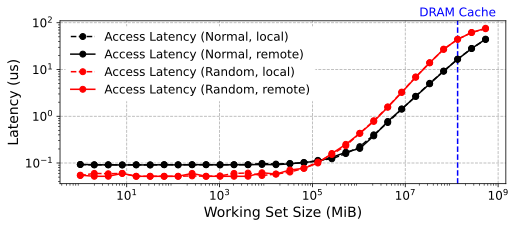

In [7]:
fontsize=12
df = pd.concat([df_local, df_remote])
# df.index = df.index * 100.0/(1024 * 1024 * 1024)
df = df.sort_index(axis=1)

ax = df.plot(zorder=3, marker='o', color=['black', 'black', 'red','red'], figsize=(8, 3), fontsize=fontsize)
ax.grid(zorder=0, linestyle='--')

linestyles=['--', '-', '--', '-']
iter = 0
for i, l in enumerate(ax.lines):
    plt.setp(l, linestyle=linestyles[iter])
    iter += 1

vline_dict = dict(
    linestyle='--',
    color='blue',
    zorder=0
)
# ax.axvline(32 * 1024, **vline_dict)
# ax.axvline(27.5 * 1024 * 1024, **vline_dict)
# ax.axvline(1 * 1024 * 1024, **vline_dict)

x = 128 * 1024 * 1024
ax.axvline(x, **vline_dict)
ax.text(s='DRAM Cache', x=x, y=np.max(df.max())*1.8, color='blue', ha='center', fontsize=fontsize)

ax.legend(frameon=True, framealpha=1, edgecolor='white', facecolor='white', fontsize=fontsize) #.remove()
ax.set_ylabel('Latency (us)', fontsize=fontsize+2)
ax.set_xlabel('Working Set Size (MiB)', fontsize=fontsize+2)
ax.set_xscale('log')
ax.set_yscale('log')

locmaj = matplotlib.ticker.LogLocator(numticks=999)
ax.yaxis.set_major_locator(locmaj)
# ax.xaxis.set_major_locator(locmaj)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs="auto",numticks=999)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

In [23]:
df_optane = pd.read_csv("../../data/workingsetsize-optane.csv", index_col=0, skiprows=[0], usecols=[0, 1, 12], names=['Working Set Size (B)', 'Access Latency (Random, Optane)', 'Access Latency (Normal, Optane)'])
display(df_optane)
df_optane['Access Latency (Random, Optane)'] = [float(val.replace('us', '')) for val in df_optane['Access Latency (Random, Optane)']]
df_optane['Access Latency (Normal, Optane)'] = [float(val.replace('us', '')) for val in df_optane['Access Latency (Normal, Optane)']]

,"Access Latency (Random, Optane)","Access Latency (Normal, Optane)"
Working Set Size (B),,
4096,0.038us,0.138us
8192,0.039us,0.138us
16384,0.040us,0.140us
32768,0.043us,0.139us
65536,0.047us,0.143us
131072,0.057us,0.147us
262144,0.075us,0.159us
524288,0.111us,0.174us
1048576,0.185us,0.207us


Working Set Size (B),4096,8192,16384,32768,65536,131072,262144,524288,1048576,2097152,4194304,8388608,16777216,33554432,67108864,134217728,268435456,536870912,1073741824,2147483648,1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384,32768,65536,131072,262144,524288,1048576,2097152,4194304,8388608,16777216,33554432,67108864,134217728,268435456,536870912
AWS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.054,0.06,0.059,0.06,0.052,0.052,0.052,0.052,0.053,0.052,0.053,0.06,0.061,0.054,0.058,0.064,0.077,0.105,0.152,0.235,0.432,0.803,1.588,3.289,6.94,13.993,26.908,44.369,61.841,74.441
Optane,0.038,0.039,0.04,0.043,0.047,0.057,0.075,0.111,0.185,0.318,0.522,0.819,1.359,2.4,4.218,6.738,9.454,12.451,14.28,15.257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


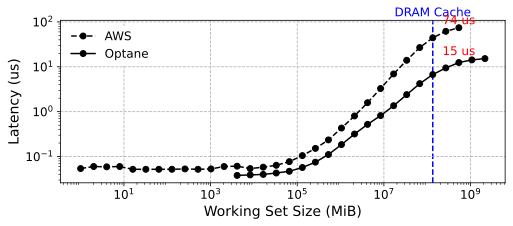

In [24]:
fontsize=12

df = pd.concat([df_optane, df_local])[['Access Latency (Random, Optane)', 'Access Latency (Random, local)']].T
name_map = {
    'Access Latency (Random, Optane)': 'Optane', 
    'Access Latency (Random, local)': 'AWS'
}
df.index = [name_map[val] for val in df.index]
df = df.T
df = df.sort_index(axis=1)
display(df.T)
ax = df.plot(zorder=3, marker='o', color=['black', 'black', 'red','red'], figsize=(8, 3), fontsize=fontsize)
ax.grid(zorder=0, linestyle='--')

linestyles=['--', '-', '--', '-']
iter = 0
for i, l in enumerate(ax.lines):
    plt.setp(l, linestyle=linestyles[iter])
    iter += 1

vline_dict = dict(
    linestyle='--',
    color='blue',
    zorder=0
)
# ax.axvline(32 * 1024, **vline_dict)
# ax.axvline(27.5 * 1024 * 1024, **vline_dict)
# ax.axvline(1 * 1024 * 1024, **vline_dict)

x = 128 * 1024 * 1024
ax.axvline(x, **vline_dict)
ax.text(s='DRAM Cache', x=x, y=np.max(df.max())*1.8, color='blue', ha='center', fontsize=fontsize)

ax.legend(frameon=True, framealpha=1, edgecolor='white', facecolor='white', fontsize=fontsize) #.remove()
ax.set_ylabel('Latency (us)', fontsize=fontsize+2)
ax.set_xlabel('Working Set Size (MiB)', fontsize=fontsize+2)
ax.set_xscale('log')
ax.set_yscale('log')

locmaj = matplotlib.ticker.LogLocator(numticks=999)
ax.yaxis.set_major_locator(locmaj)
# ax.xaxis.set_major_locator(locmaj)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs="auto",numticks=999)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
max_v = df.max()

for k, v in zip(max_v.index, max_v):
    ax.annotate(text=('%.0f us' % v), xy=(536870912, v*1.2), ha='center', fontsize=fontsize, color='red')

In [25]:
def wss_trans(val):
    div = 1
    suffix = 'B'
    if (val >= 2**30):
        div = 2**30
        suffix = 'GiB'
    elif (val >= 2**20):
        div = 2**20
        suffix = 'MiB'
    elif (val >= 2**10):
        div = 2**10
        suffix = 'KiB'
    return str(int(val//div)) + ' ' + suffix
wss_trans(256 * (10**6))

'244 MiB'

Working Set Size (B),4096,8192,16384,32768,65536,131072,262144,524288,1048576,2097152,4194304,8388608,16777216,33554432,67108864,134217728,268435456,536870912,1073741824,2147483648
"Access Latency (Random, Optane)",0.038,0.039,0.04,0.043,0.047,0.057,0.075,0.111,0.185,0.318,0.522,0.819,1.359,2.4,4.218,6.738,9.454,12.451,14.28,15.257


Working Set Size (B),4096,8192,16384,32768,65536,131072,262144,524288,1048576,2097152,4194304,8388608,16777216,33554432,67108864,134217728,268435456,536870912,1073741824,2147483648
Optane,0.038,0.039,0.04,0.043,0.047,0.057,0.075,0.111,0.185,0.318,0.522,0.819,1.359,2.4,4.218,6.738,9.454,12.451,14.28,15.257


<ipython-input-28-60c1143f0e38>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)


Plot saved as `plots/pathfinding/mss-characteristics.png`

Plot saved as `plots/pathfinding/mss-characteristics.png`

Using pdfcrop on `plots/pathfinding/mss-characteristics.png` with command `pdfcrop plots/pathfinding/mss-characteristics.pdf plots/pathfinding/mss-characteristics.pdf`

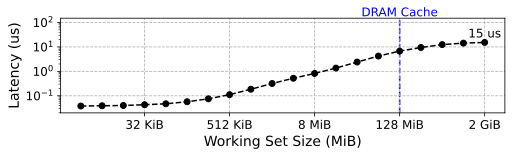

In [28]:
fontsize=12

df = df_optane[['Access Latency (Random, Optane)']].T
display(df)
name_map = {
    'Access Latency (Random, Optane)': 'Optane', 
    'Access Latency (Random, local)': 'AWS'
}
df.index = [name_map[val] for val in df.index]
df = df.T
df = df.sort_index(axis=1)
display(df.T)
ax = df.plot(zorder=3, marker='o', color=['black', 'black', 'red','red'], figsize=(8, 1.75), fontsize=fontsize)
ax.grid(zorder=0, linestyle='--')

linestyles=['--', '-', '--', '-']
iter = 0
for i, l in enumerate(ax.lines):
    plt.setp(l, linestyle=linestyles[iter])
    iter += 1

vline_dict = dict(
    linestyle='--',
    color='blue',
    zorder=0
)
# ax.axvline(32 * 1024, **vline_dict)
# ax.axvline(27.5 * 1024 * 1024, **vline_dict)
# ax.axvline(1 * 1024 * 1024, **vline_dict)

x = 128 * 1024 * 1024
ax.axvline(x, **vline_dict)
ax.text(s='DRAM Cache', x=x, y=180, color='blue', ha='center', fontsize=fontsize)
# ax.text(s='128 MiB', x=x, y=0.005, color='blue', ha='center', fontsize=fontsize)

ax.legend(frameon=True, framealpha=1, edgecolor='white', facecolor='white', fontsize=fontsize).remove()
ax.set_ylabel('Latency (us)', fontsize=fontsize+2)
ax.set_xlabel('Working Set Size (MiB)', fontsize=fontsize+2)
ax.set_xscale('log', base=2)
ax.set_yscale('log')
ax.set_ylim(0.02, 150)

locmaj = matplotlib.ticker.LogLocator(numticks=999)
ax.yaxis.set_major_locator(locmaj)
# ax.xaxis.set_major_locator(locmaj)

locmin10 = matplotlib.ticker.LogLocator(base=10.0, subs="auto", numticks=999)
locmin2 = matplotlib.ticker.LogLocator(base=2.0, subs="auto", numticks=999)
ax.yaxis.set_minor_locator(locmin10)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.xaxis.set_minor_locator(locmin2)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
max_v = df.max()

xticks = [wss_trans(val) for val in ax.get_xticks()]
ax.set_xticklabels(xticks)

for k, v in zip(max_v.index, max_v):
    ax.annotate(text=('%.0f us' % v), xy=(2 * 1024 * 1024 * 1024, v*1.6), ha='center', fontsize=fontsize, color='black')

save_fig('mss-characteristics')

In [ ]:
(3 * (2**30)) % (2**30)

In [ ]:
(4 * 2**30)